In [232]:
!nvidia-smi

Sun Aug  6 19:17:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.57       Driver Version: 515.57       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    On   | 00000000:18:00.0 Off |                  Off |
| 30%   47C    P2    66W / 230W |  18091MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [233]:

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from model import NerfModel, ReplicateNeRFModel
from utils import pose_to_rays, create_parser, DictMap
from dataloader import load_data
import tqdm

from blender_datasets import BlenderDataset

import math
import imageio
import json
import cv2
import random

device = (torch.device('cuda')
            if torch.cuda.is_available() else torch.device('cpu'))

In [234]:
def rendering(color, density, dist_delta, device, permute, rank = None):
    """
    color: (h, w, num_samples along each ray, 3)
    density: (h, w, num_samples along each ray)
    dist_delta: the distance between the two neighbouring points on a ray, 
                assume it's constant and a float
    """
    
    if len(density.shape) == 3:
        density = torch.squeeze(density)

    dist_delta[-1] = 1e10    
    density_times_delta = density * dist_delta    
    density_times_delta = density_times_delta.to(device=device)
    


    T = torch.exp(-cumsum_exclusive(density_times_delta))
    
    # roll T to right by one postion and replace the first column with 1
    S = 1 - torch.exp(-density_times_delta)
    points_color = (T * S)[..., None] * color
    C = torch.sum(points_color, dim=-2)

    if len(C.shape) == 2:
        return (C.permute(1, 0) if permute else C), S
    elif len(C.shape) == 3:
        return (C.permute(2, 0, 1) if permute else C), S


def cumsum_exclusive(t):
    dim = -1
    cumsum = torch.cumsum(t, dim)
    cumsum = torch.roll(cumsum, 1, dim)
    cumsum[..., 0] = 0.
    return cumsum

def cumprod_exclusive(t):
    dim = -1
    cumprod = torch.cumprod(t, dim)
    cumprod = torch.roll(cumprod, 1, dim)
    cumprod[..., 0] = 1.
    return cumprod

In [235]:
def get_rotation_and_translation(c2w):
    return c2w[:3, :3], c2w[:3, -1]


def show_view(c2w, focal, h, w, t_n, t_f, num_samples, chunk, **_):
    with torch.no_grad():
        rot, trans = get_rotation_and_translation(c2w)
        points, direction, ts = pose_to_rays(
            rot, trans, focal, h, w, t_n, t_f, num_samples)

        points, dirs, ts= points.to(device), direction.to(device), ts.to(device)
                    
        flat_points = points.reshape(-1, 3)
        flat_dirs = dirs.reshape(-1, 3)
        
        concat = batchify(chunk, nerf_model)(flat_points, flat_dirs)
        flat_rgbs, flat_density = concat[..., :3], concat[..., 3:]

        rgbs, density = torch.reshape(flat_rgbs, points.shape), torch.reshape(flat_density, points.shape[0:-1])

        # rendering
        # delta = (hparams.t_f - hparams.t_n) / hparams.num_samples
            
        # Change delta to be actual adjacent points
        delta = ts.roll(shifts=-1,dims=0) - ts

        rendered_image, weights = rendering(rgbs, density, delta, device, permute=False)

    return rendered_image.detach().cpu().numpy(), weights, ts


def lookat(origin, loc):
    dir = loc - origin
    dir = dir / np.linalg.norm(dir)

    tmp = np.asarray([0, 0, 1])
    right = np.cross(tmp, dir)
    up = np.cross(dir, right)

    R = np.hstack([right[..., None], up[..., None], dir[..., None]])

    return torch.tensor(np.vstack(
        [np.hstack([R, loc[..., None]]),
         np.asarray([0, 0, 0, 1])[None, ...]]))


def circle_points(z, radius, num_points):
    split = (2 * math.pi) / num_points

    vals = []
    for i in range(num_points):
        angle = split * i
        vals.append(
            np.asarray([radius * math.cos(angle), radius * math.sin(angle),
                        z]))
    return vals

def batchify(chunk, mlp):
    if chunk is None:
        return mlp

    def process_chunks(xyz, dirs):
        assert len(xyz.shape) == len(dirs.shape)
        assert [xyz.shape[i] == dirs.shape[i] for i in range(len(xyz.shape))]

        return torch.cat([torch.cat(mlp(xyz[i:i+chunk], dirs[i:i+chunk]), dim=-1) for i in range(0, xyz.shape[0], chunk)], 0)
    return process_chunks


In [236]:
with open("hparams/hparams_800.json") as json_file:
        hparams = json.load(json_file)

hparams = DictMap(hparams)

dataset = BlenderDataset(mode="train", **hparams.__dict__)
focal = dataset.focal

nerf_model = ReplicateNeRFModel(use_viewdirs=hparams.use_viewdirs
                                    ).to(device=device)

nerf_model.load_state_dict(torch.load(
    f'model_{hparams.w}x{hparams.h}_viewdir={str(hparams.use_viewdirs)}.pt', map_location=device))

camera_positions = circle_points(2, 5, 100)

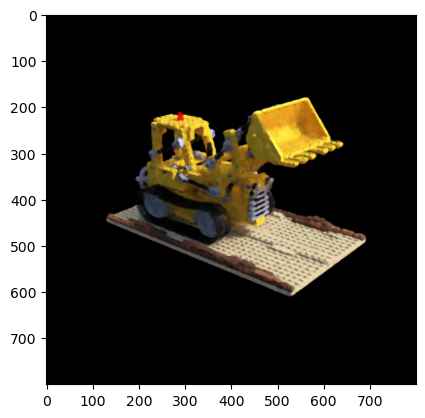

In [237]:
position = camera_positions[random.randint(0, len(camera_positions))] # get first one
c2w = lookat(np.asarray([0, 0, 0]), position).type(torch.float32)
raw_color, weights, ts = show_view(c2w, focal, **hparams.__dict__)
intermediate = (255 * np.clip(raw_color, 0, 1)).astype(np.uint8)

f, ax = plt.subplots(1,1)
ax.imshow(intermediate)
f.show()

## Pick a ray

0.0


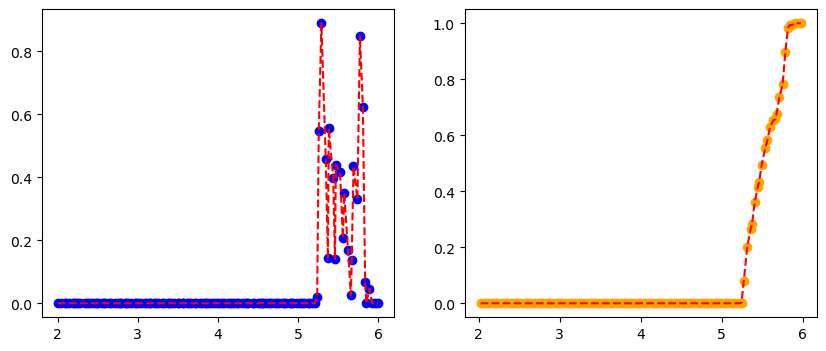

In [238]:
probs = weights[400, 400, :].cpu().numpy()
pieces = ts.cpu().numpy()

mids = 0.5 * (pieces[..., 1:] + pieces[..., :-1])
probs_norm = probs / np.sum(probs)

probs_mid = probs[..., 1:-1]
probs_mid = probs_mid / np.sum(probs_mid)
probs_mid = np.hstack([[0.0], probs_mid])
cdf_mid = np.cumsum(probs_mid)

assert(1.0 - 1e-5 <= np.sum(probs_norm) <= 1.0 + 1e-5)
assert(1.0 - 1e-5 <= np.sum(probs_mid) <= 1.0 + 1e-5)
cdf = np.cumsum(probs_norm)
# cdf = np.hstack([[0], cdf])
assert(1.0 - 1e-5 <= cdf[-1] <= 1.0 + 1e-5)

f, ax = plt.subplots(1,2)
f.set_size_inches(10, 4)
# ax.plot(pieces, cdf, linestyle="dashed", color="red")
ax[1].plot(mids, cdf_mid, linestyle="dashed", color="red")
ax[1].scatter(mids, cdf_mid, color = "orange")
ax[0].plot(pieces, probs, linestyle="dashed", color="red")
ax[0].scatter(pieces, probs, color = "blue")
# ax.scatter(pieces, cdf)
f.show()

## Inverse transform sampling

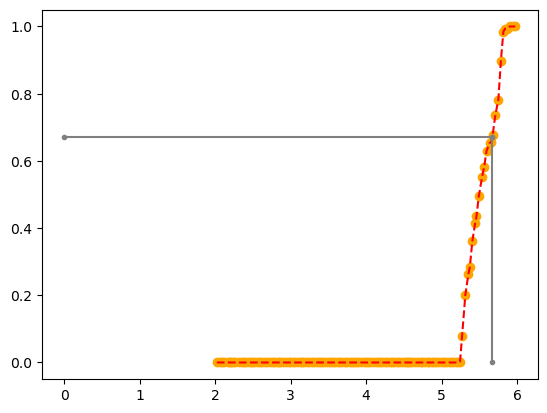

In [239]:
# Sample uniform number
u = np.random.uniform(low=0.0, high=1.0, size=None)

low = np.searchsorted(cdf, u)
low_mid = np.searchsorted(cdf_mid, u, side = "right")

l,r = low_mid -1, low_mid
diff_mids = (u - cdf_mid[l]) / (cdf_mid[r] - cdf_mid[l])
x_val_mids = (mids[r] - mids[l]) * diff_mids + mids[l]

l,r = low -1, low
diff = (u - cdf[l]) / (cdf[r] - cdf[l])
x_val = (pieces[r] - pieces[l]) * diff + pieces[l]

f, ax = plt.subplots(1,1)
ax.plot(mids, cdf_mid, linestyle="dashed", color="red")
ax.scatter(mids, cdf_mid, color = "orange")

ax.plot([0, x_val_mids], [u,u], marker = ".", color="gray")
ax.plot([x_val_mids, x_val_mids], [u,0], marker = ".", color="gray")
f.show()